In [1]:
'''
#Gigacow-tools# - data collection for prolonged problematic cows.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction.settings import from_columns
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

pd.options.mode.chained_assignment = None

#access data from local directory
dataDir = Path.cwd().parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

Gigacow_Cow_Id
5613    17247
4504    16330
5046    15623
5147    15440
3147    15303
478     14751
6380    14514
1181    14434
4478    14434
1985    14419
Name: count, dtype: int64


In [2]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

def lac_collect(NumLac, milking_total):
    """Generate cow list for multiple lactation periods.(30-60 DIM)

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period #num
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 40]
        # select sufficient data points on lactation 1
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 30) & (selected1.values < 40)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

#Calls lac_collect specifying that it will filter out rows with 30 < Days in milk <40 in lactation 1 and 2
cow_list = lac_collect(2, milking_total)
#cow_list = [3718, 2569, 1555, 5147, 1181, 926, 5160, 182, 5046, 1985, 1738, 74, 1103, 478, 5088, 5092, 2278, 6380, 2423, 3707]

159 [2560, 2568, 6153, 5645, 4109, 6164, 5147, 544, 3104, 1057, 550, 5160, 2090, 3629, 4142, 48, 571, 2112, 3657, 74, 3149, 6222, 1103, 4176, 2135, 1113, 5211, 603, 6241, 4195, 5225, 4714, 5235, 5239, 3705, 4730, 3200, 645, 3718, 5767, 3206, 2694, 3207, 5262, 2702, 151, 6300, 1181, 4765, 5279, 4769, 5284, 1705, 5301, 2742, 4792, 4280, 2746, 702, 708, 4295, 1738, 2251, 1744, 5844, 5846, 5848, 6361, 1755, 1244, 5852, 4318, 223, 2278, 2792, 3822, 5873, 4341, 2805, 5372, 1277, 769, 4358, 4871, 4362, 1812, 4374, 2844, 287, 289, 6434, 6439, 4910, 3887, 1842, 3890, 2868, 6452, 1331, 829, 6463, 2374, 4939, 5965, 2382, 2386, 342, 855, 856, 5465, 5978, 3422, 2409, 1393, 3441, 1905, 6004, 3446, 3447, 1910, 4988, 4990, 385, 6018, 3979, 3468, 2956, 6039, 2460, 5534, 3487, 2466, 2979, 4008, 4524, 4525, 4012, 943, 951, 1464, 1985, 4038, 2510, 978, 5076, 2517, 478, 5088, 5092, 3045, 3560, 3563, 3052, 5612, 6127, 5616, 1012, 507, 2047]
65 [2560, 769, 385, 6018, 3718, 5767, 2702, 151, 5147, 2844, 4765, 

In [3]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

    #select single cow from the traffic table

# select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id, lacNumList):
    '''
    func: collect features from for a single cow
    args: 
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: gigacow_id of the cow
        lacNumList: a list lactation period number
    return: A dataframe contains all features for a single cow on specfic lactation period
    '''

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    # extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge.dropna(inplace=True)

    # integrate multiple milking events for a single DIM
    single_cow_merge = single_cow_merge[single_cow_merge.LactationNumber.isin(lacNumList)]
    single_cow_merge.index = range(1,len(single_cow_merge)+1) 
    single_cow_merge.drop(['MilkingEventDateTime', 'Pre_MilkingEventDateTime', 'Traffic_Id', 'MilkingInterval_totalSeconds', 'RoundedSecondsTimeInArea', 'PreviousArea', 'GroupName', 'LactationInfoDate', 'TrafficDeviceName'], axis=1, inplace=True)

    comb_cows = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).sum(['MilkProduction', 'timeDelta_Seconds'])
    single_cow_merge_size = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).size()
    comb_cows = pd.concat([comb_cows, single_cow_merge_size['size']], axis=1, ignore_index=False)
    comb_cows.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    comb_cows.index = range(1, len(comb_cows)+1)
    return comb_cows

In [4]:
periods = [1, 2]
Path(dataDir/'prolonged_problematic_targetCows').mkdir(parents=True, exist_ok=True)
for p in periods:
    Path(dataDir/'prolonged_problematic_targetCows'/str(p)).mkdir(parents=True, exist_ok=True)

print(dataDir)

for i, cow_id in enumerate(cow_list):
    for p in periods:
        single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, [p])
        single_cow_merge = single_cow_merge.loc[(single_cow_merge.DaysInMilk < 40)]

        single_cow_merge["id"] = i + 1
        # Check if the DataFrame has rows before saving
        if single_cow_merge.shape[0] > 0:  # Check if there are rows
            fileName = 'prolonged_problematic_targetCows/' + str(p) + '/cow_' + str(i) + '.csv'
            single_cow_merge.to_csv(dataDir/fileName)
        
print("num of cows: ", len(cow_list))


c:\Users\tokm0001\OneDrive - Sveriges lantbruksuniversitet\Dokument\Gigacow-tools-cleaning\Projects\Data\processed
num of cows:  65


In [5]:
""" Data Preparation """

dataDir = Path.cwd().parent.parent/'Data/processed/prolonged_problematic_targetCows/'
usecols = ['id', 'FarmName_Pseudo', 'Gigacow_Cow_Id', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age', 'milking_times', 'MilkingDate']

# labeling cow with prolonged problematic behavior(1/0)
def labeling_memory(threshold_percentage, cow_l1, cow_l2): 
    '''
    func: labeling prolonged problematic dataset
    args: 
        threshold_percentage: threshold for the ratio of milking time cost reduction
        cow_l1: A dataframe contains all data points for a single cow on lactation period 1
        cow_l2: A dataframe contains all data points for a single cow on lactation period 2
    return: prolonged problematic dataset with label
    '''
    global prob
    total_timeCost_1 = 0
    total_timeCost_2 = 0
    # lactation period 1
    total_timeCost_1 = cow_l1.Total_timeDelta_Seconds.sum()
    totalEvents_1 = cow_l1.milking_times.sum()
    mean_timeCost_1 = total_timeCost_1/totalEvents_1
    # lactation period 2
    total_timeCost_2 = cow_l2.Total_timeDelta_Seconds.sum()
    totalEvents_2 = cow_l2.milking_times.sum()
    mean_timeCost_2 = total_timeCost_2/totalEvents_2
    time_diff = (mean_timeCost_1-mean_timeCost_2)/mean_timeCost_1
    # print("cow: " + str(time_diff))
    # print(mean_timeCost_1)
    # print(mean_timeCost_2)
    
    # anomalies detection
    if time_diff < 0.1:
        print(cow_l1.FarmName_Pseudo.unique())
        print(time_diff)
        prob = 2
        return prob
    print(time_diff)
    if time_diff > threshold_percentage:
        prob = 1 # normal behavior
        print("normal behavior")
    else:
        prob = 0 # exist prolonged problematic behavior
        print("prolonged problematic behavior")
    return prob


In [8]:
# periods = os.listdir(dataDir)
periods = [1, 2]

filelist = list(Path(dataDir/'1').glob('*.csv'))

# integrate all the cows data into one dataset
filelist = list(Path(dataDir/'1').glob('*.csv'))

# integrate all the cows data into one dataset
for i, _ in enumerate(filelist):
    fileName = 'cow_' + str(i) + '.csv'

    # Check if the file exists before reading it
    if not Path(dataDir/'1'/fileName).is_file():
        continue

    single_cow_1 = pd.read_csv(dataDir/'1'/fileName, encoding='utf-8', usecols=usecols)
    single_cow_2 = pd.read_csv(dataDir/'2'/fileName, encoding='utf-8', usecols=usecols)
    single_cow_1.sort_values(by=['MilkingDate'], inplace=True)
    single_cow_2.sort_values(by=['MilkingDate'], inplace=True)

    print(i)
    label = labeling_memory(0.65, single_cow_1, single_cow_2)
    # skip anomalies
    if label == 2:
        continue
    single_cow = pd.concat([single_cow_1, single_cow_2], axis=0, ignore_index=True)
    single_cow['label'] = label
    if i == 0:
        cow_total = single_cow
        cow_total_1 = single_cow_1
        cow_total_2 = single_cow_2
    else:
        cow_total = pd.concat([cow_total, single_cow], axis=0, ignore_index=True)
        cow_total_1 = pd.concat([cow_total_1, single_cow_1], axis=0, ignore_index=True)
        cow_total_2 = pd.concat([cow_total_2, single_cow_2], axis=0, ignore_index=True)

# add extra columns for mean_Total_timeDelta_Seconds
cow_total_1["mean_Total_timeDelta_Seconds"] = cow_total_1.Total_timeDelta_Seconds/cow_total_1.milking_times
cow_total_2["mean_Total_timeDelta_Seconds"] = cow_total_2.Total_timeDelta_Seconds/cow_total_2.milking_times
cow_total["mean_Total_timeDelta_Seconds"] = cow_total.Total_timeDelta_Seconds/cow_total.milking_times

fileName = 'Cow_prolonged_problematic_dataset_L1_L2.csv'
Path(dataDir/'cow_total/').mkdir(parents=True, exist_ok=True)
cow_total.to_csv(dataDir/'cow_total'/fileName, index=False)
cow_total_1.to_csv(dataDir/'cow_total/Cow_prolonged_problematic_dataset_L1.csv', index=False)
cow_total_2.to_csv(dataDir/'cow_total/Cow_prolonged_problematic_dataset_L2.csv', index=False)

0
0.45203299852200396
prolonged problematic behavior
1
0.1321973542312047
prolonged problematic behavior
2
0.1262050467660092
prolonged problematic behavior
3
0.4793711608916756
prolonged problematic behavior
4
0.6682159152012692
normal behavior
5
0.3213034803812902
prolonged problematic behavior
6
0.41262784063178254
prolonged problematic behavior
7
0.4127983899167269
prolonged problematic behavior
8
0.6687787308106531
normal behavior
9
0.7107626198685439
normal behavior
10
0.3920218816057465
prolonged problematic behavior
11
0.7661651953328444
normal behavior
13
0.664177866761014
normal behavior
14
0.7277845810385657
normal behavior
15
0.5679763312802878
prolonged problematic behavior
16
0.8652682769990042
normal behavior
17
0.35323895701425423
prolonged problematic behavior
18
0.4673379381314594
prolonged problematic behavior
19
0.17590577523715614
prolonged problematic behavior
20
0.5643636918877408
prolonged problematic behavior
21
0.22105594788025784
prolonged problematic behavio

In [9]:
# set up parameters used in the model

para_dict = {
'Age': {'sum_values': None, 'length': None},
'Total_MilkProduction': {'root_mean_square': None,
                         'standard_deviation': None,
                         'variance': None,
                         'mean': None,
                         'median': None,
                         'maximum': None,
                         'length': None,
                         'sum_values': None},
'mean_Total_timeDelta_Seconds': {'length': None,
                                 'minimum': None,
                                 'sum_values': None,
                                 'absolute_maximum': None,
                                 'maximum': None,
                                 'standard_deviation': None,
                                 'variance': None,
                                 'median': None,
                                 'root_mean_square': None,
                                 'mean': None},
'DaysInMilk': {'sum_values': None, 'length': None},
'milking_times': {'length': None,
                  'variance': None,
                  'standard_deviation': None,
                  'median': None,
                  'absolute_maximum': None,
                  'maximum': None,
                  'mean': None,
                  'root_mean_square': None,
                  'sum_values': None}
}

In [10]:
""" Feature Engineering"""

static_cols = ['FarmName_Pseudo', 'TrafficDeviceName', 'LactationNumber', 'BreedName']
# timeSeries_cols = ['Age', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'DaysInMilk', 'milking_times']
timeSeries_cols = ['DaysInMilk', 'Total_MilkProduction',  'Age', 'mean_Total_timeDelta_Seconds', 'milking_times']
output_col = ['label']

cow_label = cow_total[['id', 'label']].copy()
# fetch y for feature extraction
y = cow_label.drop_duplicates(subset=['id'])
y = y["label"]
y.index = range(1, len(y)+1)

# extract features from cow dataset in lactation period 1
ts_extracted_dataset_1 = cow_total_1[['id']].copy()
ts_extracted_dataset_1.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset_1.index = ts_extracted_dataset_1.id

cow_timeseries = cow_total_1[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))

for col in timeSeries_cols:
    ts_processed = pd.DataFrame(cow_total_1[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    print(ts_processed)
    # extract time series features
    extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", kind_to_fc_parameters=para_dict)
    # extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate")
    # extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_dataset)
    # features_filtered = select_features(extracted_dataset, y)
    ts_extracted_dataset_1 = pd.concat([ts_extracted_dataset_1, extracted_dataset], axis=1)
ts_extracted_dataset_1

      id MilkingDate  DaysInMilk
0      1  2022-02-14         2.0
1      1  2022-02-15         3.0
2      1  2022-02-16         4.0
3      1  2022-02-17         5.0
4      1  2022-02-18         6.0
...   ..         ...         ...
2245  64  2022-01-04        35.0
2246  64  2022-01-05        36.0
2247  64  2022-01-06        37.0
2248  64  2022-01-07        38.0
2249  64  2022-01-08        39.0

[2250 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 15.28it/s]


      id MilkingDate  Total_MilkProduction
0      1  2022-02-14                 17.84
1      1  2022-02-15                 14.02
2      1  2022-02-16                 24.07
3      1  2022-02-17                 21.00
4      1  2022-02-18                 21.91
...   ..         ...                   ...
2245  64  2022-01-04                 38.40
2246  64  2022-01-05                 31.25
2247  64  2022-01-06                 39.91
2248  64  2022-01-07                 38.12
2249  64  2022-01-08                 31.58

[2250 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:01<00:00, 16.18it/s]


      id MilkingDate   Age
0      1  2022-02-14  2.15
1      1  2022-02-15  2.15
2      1  2022-02-16  2.15
3      1  2022-02-17  2.15
4      1  2022-02-18  2.16
...   ..         ...   ...
2245  64  2022-01-04  2.20
2246  64  2022-01-05  2.21
2247  64  2022-01-06  2.21
2248  64  2022-01-07  2.21
2249  64  2022-01-08  2.21

[2250 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 15.33it/s]


      id MilkingDate  mean_Total_timeDelta_Seconds
0      1  2022-02-14                       1764.00
1      1  2022-02-15                       5135.50
2      1  2022-02-16                       2824.25
3      1  2022-02-17                        902.00
4      1  2022-02-18                        771.00
...   ..         ...                           ...
2245  64  2022-01-04                        288.40
2246  64  2022-01-05                        645.00
2247  64  2022-01-06                        836.20
2248  64  2022-01-07                        383.40
2249  64  2022-01-08                        190.00

[2250 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.88it/s]


      id MilkingDate  milking_times
0      1  2022-02-14              2
1      1  2022-02-15              2
2      1  2022-02-16              4
3      1  2022-02-17              4
4      1  2022-02-18              3
...   ..         ...            ...
2245  64  2022-01-04              5
2246  64  2022-01-05              4
2247  64  2022-01-06              5
2248  64  2022-01-07              5
2249  64  2022-01-08              4

[2250 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.31it/s]


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,779.0,38.0,31.241808,6.256429,39.142904,30.608947,30.465,39.23,38.0,...,1037.875439,38.0,0.468837,0.684716,4.0,5.0,5.0,3.710526,3.773174,141.0
2,2,780.0,39.0,25.780897,6.467785,41.832249,24.956410,25.940,35.40,39.0,...,1534.348291,39.0,0.407627,0.638456,3.0,4.0,4.0,2.948718,3.017046,115.0
3,3,780.0,39.0,26.332611,5.460364,29.815572,25.760256,25.420,35.19,39.0,...,1595.696581,39.0,0.481262,0.693731,3.0,4.0,4.0,2.923077,3.004270,114.0
4,4,755.0,34.0,28.169897,7.694987,59.212818,27.098529,27.730,39.08,34.0,...,7043.549020,34.0,0.439446,0.662908,2.0,3.0,3.0,2.176471,2.275186,74.0
5,5,594.0,33.0,32.280143,6.990004,48.860158,31.514242,33.250,42.12,33.0,...,1103.145960,33.0,0.550964,0.742270,3.0,5.0,5.0,3.454545,3.533391,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,780.0,39.0,32.571190,6.251415,39.080184,31.965641,32.350,44.75,39.0,...,1547.790598,39.0,0.356345,0.596946,3.0,4.0,4.0,3.051282,3.109126,119.0
61,61,779.0,38.0,25.790453,6.234619,38.870477,25.025526,25.785,36.45,38.0,...,1597.313596,38.0,0.418283,0.646748,3.0,4.0,4.0,2.947368,3.017493,112.0
62,62,780.0,39.0,24.266334,8.434500,71.140791,22.753333,23.560,41.73,39.0,...,2335.865385,39.0,0.656147,0.810029,2.0,4.0,4.0,2.435897,2.567050,95.0
63,63,779.0,38.0,29.414908,5.631546,31.714313,28.870789,29.440,39.48,38.0,...,791.891228,38.0,0.626731,0.791664,3.0,5.0,5.0,3.289474,3.383396,125.0


In [11]:
# extract features from cow dataset in lactation period 2

ts_extracted_dataset_2 = cow_total_2[['id']].copy()
ts_extracted_dataset_2.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset_2.index = ts_extracted_dataset_2.id

cow_timeseries = cow_total_2[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))

for col in timeSeries_cols:
    ts_processed = pd.DataFrame(cow_total_2[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    print(ts_processed)
    # extract time series features
    extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", kind_to_fc_parameters=para_dict)
    # extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_dataset)
    # features_filtered = select_features(extracted_dataset, y)
    ts_extracted_dataset_2 = pd.concat([ts_extracted_dataset_2, extracted_dataset], axis=1)
ts_extracted_dataset_2

      id MilkingDate  DaysInMilk
0      1  2023-01-31         2.0
1      1  2023-02-01         3.0
2      1  2023-02-02         4.0
3      1  2023-02-03         5.0
4      1  2023-02-04         6.0
...   ..         ...         ...
2302  64  2022-12-14        35.0
2303  64  2022-12-15        36.0
2304  64  2022-12-16        37.0
2305  64  2022-12-17        38.0
2306  64  2022-12-18        39.0

[2307 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.36it/s]


      id MilkingDate  Total_MilkProduction
0      1  2023-01-31                 26.78
1      1  2023-02-01                 31.79
2      1  2023-02-02                 31.54
3      1  2023-02-03                 24.88
4      1  2023-02-04                 35.61
...   ..         ...                   ...
2302  64  2022-12-14                 48.78
2303  64  2022-12-15                 50.43
2304  64  2022-12-16                 49.75
2305  64  2022-12-17                 45.25
2306  64  2022-12-18                 24.27

[2307 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 15.03it/s]


      id MilkingDate   Age
0      1  2023-01-31  3.11
1      1  2023-02-01  3.11
2      1  2023-02-02  3.11
3      1  2023-02-03  3.12
4      1  2023-02-04  3.12
...   ..         ...   ...
2302  64  2022-12-14  3.15
2303  64  2022-12-15  3.15
2304  64  2022-12-16  3.15
2305  64  2022-12-17  3.15
2306  64  2022-12-18  3.16

[2307 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.63it/s]


      id MilkingDate  mean_Total_timeDelta_Seconds
0      1  2023-01-31                    173.750000
1      1  2023-02-01                    272.750000
2      1  2023-02-02                    401.250000
3      1  2023-02-03                    176.666667
4      1  2023-02-04                    132.750000
...   ..         ...                           ...
2302  64  2022-12-14                    438.500000
2303  64  2022-12-15                    125.250000
2304  64  2022-12-16                    979.000000
2305  64  2022-12-17                    220.750000
2306  64  2022-12-18                     80.000000

[2307 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.89it/s]


      id MilkingDate  milking_times
0      1  2023-01-31              4
1      1  2023-02-01              4
2      1  2023-02-02              4
3      1  2023-02-03              3
4      1  2023-02-04              4
...   ..         ...            ...
2302  64  2022-12-14              4
2303  64  2022-12-15              4
2304  64  2022-12-16              4
2305  64  2022-12-17              4
2306  64  2022-12-18              2

[2307 rows x 3 columns]


Feature Extraction: 100%|██████████| 31/31 [00:02<00:00, 14.87it/s]


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,779.0,38.0,41.368889,7.045756,49.642677,40.764474,40.690,52.80,38.0,...,529.322368,38.0,0.205679,0.453518,4.0,4.0,4.0,3.710526,3.738139,141.0
2,2,780.0,39.0,39.368391,8.777392,77.042609,38.377436,39.860,51.13,39.0,...,1197.713675,39.0,0.335306,0.579056,3.0,4.0,4.0,3.153846,3.206564,123.0
3,3,780.0,39.0,40.513907,9.516937,90.572090,39.380256,37.460,62.09,39.0,...,1390.670940,39.0,0.454964,0.674510,3.0,4.0,4.0,3.179487,3.250247,124.0
4,4,770.0,35.0,40.879112,11.450868,131.122379,39.242571,39.600,61.92,35.0,...,3716.109524,35.0,0.404898,0.636316,2.0,3.0,3.0,2.371429,2.455315,83.0
5,5,779.0,38.0,37.726876,5.629693,31.693446,37.304474,38.005,48.82,38.0,...,359.662281,38.0,0.382964,0.618841,3.0,4.0,4.0,3.342105,3.398916,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,780.0,39.0,48.693661,10.718940,114.895679,47.499231,49.460,66.78,39.0,...,1031.339744,39.0,0.366864,0.605693,3.0,4.0,4.0,3.307692,3.362691,129.0
61,61,780.0,39.0,35.406289,10.768545,115.961558,33.728974,34.480,53.04,39.0,...,770.476496,39.0,0.356345,0.596946,3.0,4.0,4.0,3.282051,3.335896,128.0
62,62,779.0,38.0,35.353627,5.535157,30.637965,34.917632,35.410,49.32,38.0,...,504.912281,38.0,0.286011,0.534800,3.0,4.0,4.0,3.236842,3.280725,123.0
63,63,780.0,39.0,41.885809,8.749420,76.552348,40.961795,42.900,57.46,39.0,...,468.054274,39.0,0.435240,0.659727,4.0,5.0,5.0,3.974359,4.028743,155.0


In [12]:
# concatenate datasets and normalize features
ts_extracted_dataset_2.drop(['id'], axis=1, inplace=True)
ts_extracted_dataset = pd.concat([ts_extracted_dataset_1, ts_extracted_dataset_2], axis=1)
nunique = ts_extracted_dataset.nunique()
cols_to_drop = nunique[nunique == 1].index
ts_extracted_dataset.drop(cols_to_drop, axis=1, inplace=True)

ts_extracted_dataset.index = range(1, len(ts_extracted_dataset)+1)
ts_extracted_features = ts_extracted_dataset.iloc[:, 1:len(ts_extracted_dataset.columns)].copy()
# normalize numerical features
ts_extracted_cols = ts_extracted_features.columns
scaler_std = StandardScaler()
ts_std = scaler_std.fit_transform(ts_extracted_features)
# transform standard data into dataframe
ts_extracted_processed = pd.DataFrame(ts_std, columns=ts_extracted_cols)
ts_extracted_processed.index = range(1,len(ts_extracted_processed)+1)
# append id col to the dataframe
ts_extracted_processed = pd.concat([ts_extracted_dataset['id'], ts_extracted_processed], axis=1)
ts_extracted_processed

,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,0.296954,0.317764,0.811958,-0.342991,-0.447891,0.854873,0.684900,0.121957,0.317764,...,-0.464851,0.202512,-1.119891,-1.453316,1.118086,-0.620954,-0.620954,0.713942,0.661689,0.633196
2,2,0.305814,0.503626,-0.225404,-0.173928,-0.278531,-0.214867,-0.130308,-0.437546,0.503626,...,0.138204,0.458752,-0.530903,-0.559309,-0.215016,-0.620954,-0.620954,-0.152555,-0.187093,0.013330
3,3,0.305814,0.503626,-0.120599,-0.979757,-1.035276,-0.062739,-0.223990,-0.468224,0.503626,...,0.312299,0.458752,0.012789,0.120460,-0.215016,-0.620954,-0.620954,-0.112644,-0.117344,0.047767
4,4,0.084313,-0.425684,0.228414,0.807700,0.816003,0.190528,0.192172,0.100044,-0.425684,...,2.410421,-0.566208,-0.214696,-0.151536,-1.548119,-1.720930,-1.720930,-1.370422,-1.386634,-1.364149
5,5,-1.342153,-0.611546,1.009201,0.243790,0.164049,1.026199,1.186637,0.544141,-0.611546,...,-0.617926,0.202512,-0.314358,-0.275984,-0.215016,-0.620954,-0.620954,0.140478,0.120042,0.151078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,60,0.305814,0.503626,1.064489,-0.347002,-0.451841,1.111626,1.024496,0.928342,0.503626,...,-0.011907,0.458752,-0.387512,-0.369616,-0.215016,-0.620954,-0.620954,0.086913,0.062200,0.219952
59,61,0.296954,0.317764,-0.223588,-0.360436,-0.465047,-0.201787,-0.158233,-0.284158,0.317764,...,-0.247270,0.458752,-0.435309,-0.431906,-0.215016,-0.620954,-0.620954,0.047002,0.019416,0.185515
60,62,0.305814,0.503626,-0.513112,1.399232,1.567162,-0.631798,-0.559081,0.487168,0.503626,...,-0.486875,0.202512,-0.754884,-0.874473,-0.215016,-0.620954,-0.620954,-0.023368,-0.068678,0.013330
61,63,0.296954,0.317764,0.464917,-0.842830,-0.915703,0.525927,0.500240,0.158478,0.317764,...,-0.520130,0.458752,-0.076831,0.015185,1.118086,0.479022,0.479022,1.124608,1.125704,1.115314


In [13]:
# add one-hot encoded categorical features
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
cow_breed = cow_total[['id', 'BreedName']].copy()
cow_breed.drop_duplicates(subset=['id'], inplace=True)
cat = ohe.fit_transform(np.array(cow_breed['BreedName']).reshape(-1, 1))
col_names = ohe.get_feature_names_out(['BreedName'])
cat_breed = pd.DataFrame(cat, columns=col_names)
cat_breed.index = range(1,len(cow_breed)+1)

ts_dataset = pd.concat([ts_extracted_processed, cat_breed], axis=1)
ts_dataset = pd.concat([ts_dataset, y], axis=1)
ts_dataset.to_csv(dataDir.parent/"prolonged_problematic_24cows_meanCost_minPara_65%.csv", index=False)
ts_dataset

C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values,BreedName_1,BreedName_2,BreedName_4,BreedName_99,label
1,1,0.296954,0.317764,0.811958,-0.342991,-0.447891,0.854873,0.684900,0.121957,0.317764,...,-0.620954,-0.620954,0.713942,0.661689,0.633196,1.0,0.0,0.0,0.0,0
2,2,0.305814,0.503626,-0.225404,-0.173928,-0.278531,-0.214867,-0.130308,-0.437546,0.503626,...,-0.620954,-0.620954,-0.152555,-0.187093,0.013330,0.0,1.0,0.0,0.0,0
3,3,0.305814,0.503626,-0.120599,-0.979757,-1.035276,-0.062739,-0.223990,-0.468224,0.503626,...,-0.620954,-0.620954,-0.112644,-0.117344,0.047767,1.0,0.0,0.0,0.0,0
4,4,0.084313,-0.425684,0.228414,0.807700,0.816003,0.190528,0.192172,0.100044,-0.425684,...,-1.720930,-1.720930,-1.370422,-1.386634,-1.364149,0.0,1.0,0.0,0.0,0
5,5,-1.342153,-0.611546,1.009201,0.243790,0.164049,1.026199,1.186637,0.544141,-0.611546,...,-0.620954,-0.620954,0.140478,0.120042,0.151078,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,60,0.305814,0.503626,1.064489,-0.347002,-0.451841,1.111626,1.024496,0.928342,0.503626,...,-0.620954,-0.620954,0.086913,0.062200,0.219952,0.0,1.0,0.0,0.0,0
59,61,0.296954,0.317764,-0.223588,-0.360436,-0.465047,-0.201787,-0.158233,-0.284158,0.317764,...,-0.620954,-0.620954,0.047002,0.019416,0.185515,0.0,1.0,0.0,0.0,0
60,62,0.305814,0.503626,-0.513112,1.399232,1.567162,-0.631798,-0.559081,0.487168,0.503626,...,-0.620954,-0.620954,-0.023368,-0.068678,0.013330,1.0,0.0,0.0,0.0,1
61,63,0.296954,0.317764,0.464917,-0.842830,-0.915703,0.525927,0.500240,0.158478,0.317764,...,0.479022,0.479022,1.124608,1.125704,1.115314,0.0,1.0,0.0,0.0,0


In [14]:
""" Prediction """

grid = dict()
# grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),1*Matern()+1*WhiteKernel(noise_level=0.5)]
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


dataDir = Path.cwd().parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"prolonged_problematic_24cows_meanCost_minPara_65%.csv", index_col="id")

X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

Mean cross-validated score of the best_estimator:  0.9451282051282051
Best estimator parameters:  {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.933 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.945 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.926 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.933 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.926 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy 0.739 with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy 0.845 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
8 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\lo

In [15]:
best_kernel = 1**2 * DotProduct(sigma_0=1)
# best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)

model = GaussianProcessClassifier(kernel=best_kernel, random_state=5, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [0 0 0 0 0 1 0 0 0 0 0 1 1]
Prediction accuracy on test data:  0.9230769230769231


In [16]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.87198218, 0.12801782],
       [0.76693596, 0.23306404],
       [0.9327133 , 0.0672867 ],
       [0.85168559, 0.14831441],
       [0.92889178, 0.07110822],
       [0.28334158, 0.71665842],
       [0.52325727, 0.47674273],
       [0.61069882, 0.38930118],
       [0.83281906, 0.16718094],
       [0.93889222, 0.06110778],
       [0.86917782, 0.13082218],
       [0.43450145, 0.56549855],
       [0.30050781, 0.69949219]])

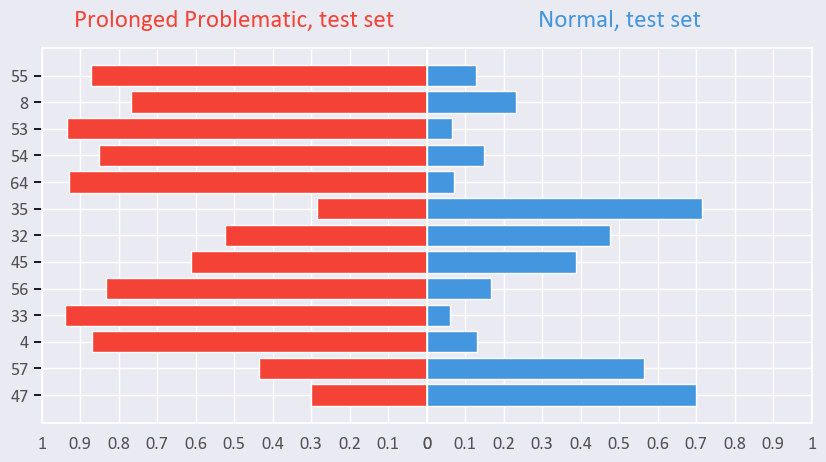

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#f44336'
color_blue = '#4496df'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Prolonged Problematic, test set'
title1 = 'Normal, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'Prolonged_Problematic_Cows'
plt.savefig(filename+'.png', facecolor=facecolor)